In [1]:
!pip install kaggle

Import Library

In [2]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from collections import defaultdict
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

Sumber dataset: https://www.kaggle.com/datasets/alexteboul/english-premier-league-logo-detection-20k-images

Download

In [3]:
!kaggle datasets download alexteboul/english-premier-league-logo-detection-20k-images

Dataset URL: https://www.kaggle.com/datasets/alexteboul/english-premier-league-logo-detection-20k-images
License(s): CC0-1.0
 99% 518M/521M [00:09<00:00, 55.3MB/s]
100% 521M/521M [00:09<00:00, 56.2MB/s]


ekstrak

In [4]:
extract_dir = 'data/'
os.makedirs(extract_dir, exist_ok=True)
zipfile.ZipFile('english-premier-league-logo-detection-20k-images.zip', 'r').extractall(extract_dir)
extract_dir = 'data/epl-logos-big/epl-logos-big'

## **Data Preparation**

Lihat distribusi data

In [5]:
def count_images(root_dir):
    image_counts = defaultdict(int)
    allowed_extensions = ['.jpg', '.jpeg', '.png', '.gif']

    for root, dirs, files in os.walk(root_dir):
        category = os.path.basename(root)
        for file in files:
            _, ext = os.path.splitext(file)
            if ext.lower() in allowed_extensions:
                image_counts[category] += 1

    return image_counts

image_counts = count_images(extract_dir)
for category, count in image_counts.items():
    print(f"Jumlah gambar '{category}': {count}")

total_images = sum(image_counts.values())
print(f"Total jumlah gambar keseluruhan: {total_images}")

Jumlah gambar 'aston-villa': 1000
Jumlah gambar 'burnley': 1000
Jumlah gambar 'newcastle': 1000
Jumlah gambar 'brighton': 1000
Jumlah gambar 'wolves': 1000
Jumlah gambar 'tottenham': 1000
Jumlah gambar 'liverpool': 1000
Jumlah gambar 'manchester-united': 1000
Jumlah gambar 'brentford': 1000
Jumlah gambar 'southampton': 1000
Jumlah gambar 'leicester-city': 1000
Jumlah gambar 'everton': 1000
Jumlah gambar 'west-ham': 1000
Jumlah gambar 'crystal-palace': 1000
Jumlah gambar 'arsenal': 1000
Jumlah gambar 'watford': 1000
Jumlah gambar 'leeds': 1000
Jumlah gambar 'chelsea': 1000
Jumlah gambar 'manchester-city': 1000
Jumlah gambar 'norwich': 1000
Total jumlah gambar keseluruhan: 20000


**Plot Distribusi data**

Terlihat jika distribusi data kurang maksimal:

<ipython-input-6-853bb83cc71d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)


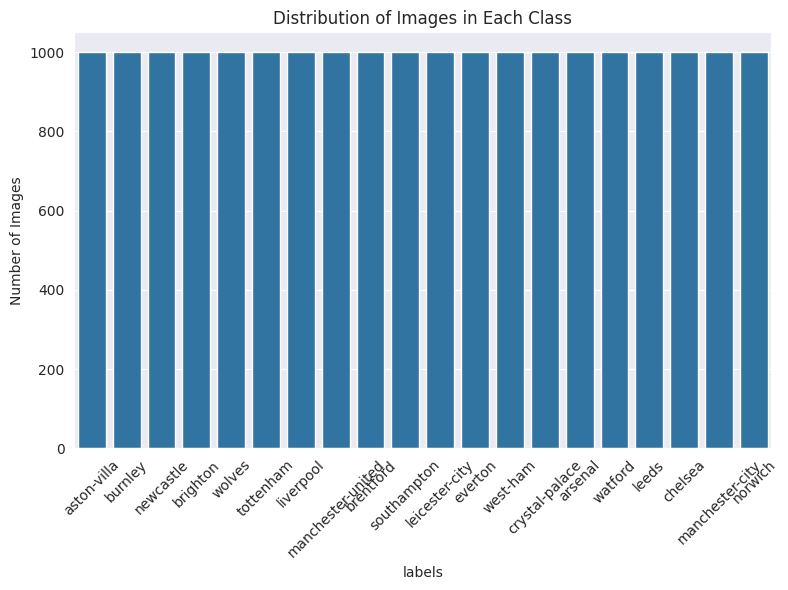

In [6]:
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(extract_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_train)
plot_data.set_title('Distribution of Images in Each Class')
plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

tampilkan sample dari masing masing kelas


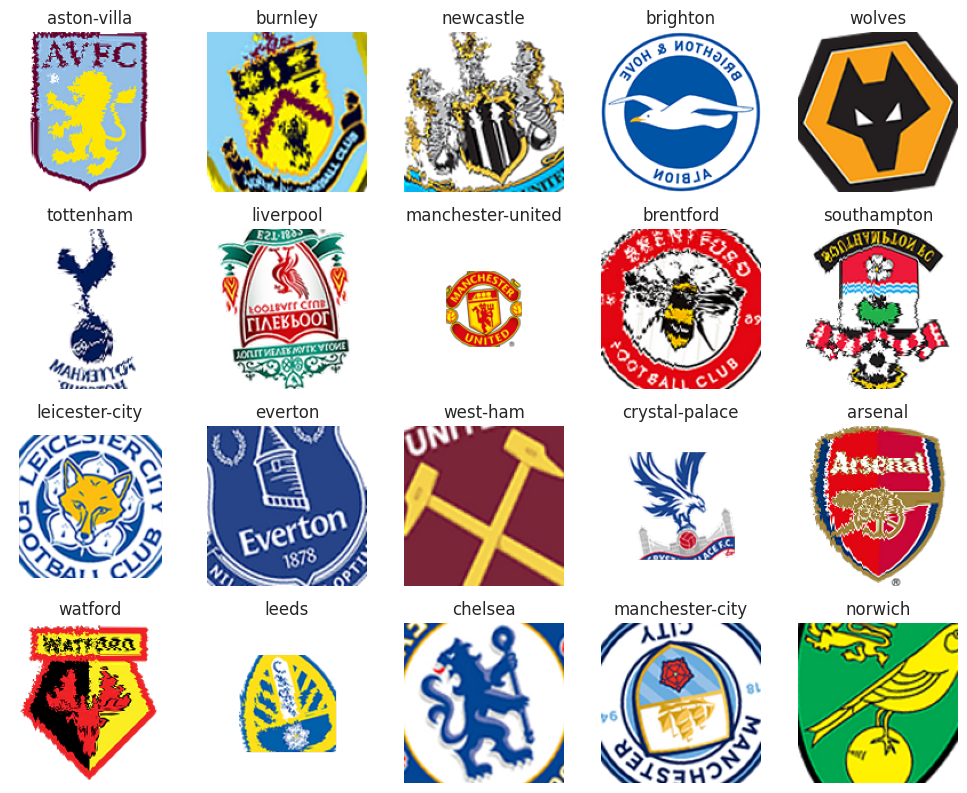

In [7]:
num_images = len(image_counts)
grid_size = int(num_images ** 0.5) + 1

plt.figure(figsize=(10, 10))
for i, (category, count) in enumerate(image_counts.items(), 1):
    if i > grid_size * grid_size:
        break
    image_path = os.path.join(extract_dir, category, os.listdir(os.path.join(extract_dir, category))[0])
    image = plt.imread(image_path)
    plt.subplot(grid_size, grid_size, i)
    plt.imshow(image)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()

Split dataset

In [9]:
categories = os.listdir(extract_dir)
train_dir = 'data_balanced/train'
test_dir = 'data_balanced/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
image_extensions = ('.jpg', '.jpeg', '.png', '.gif')

for category in categories:
    class_path = os.path.join(extract_dir, category)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(image_extensions)]

        if len(images) > 0:
            train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

            train_category_dir = os.path.join(train_dir, category)
            test_category_dir = os.path.join(test_dir, category)
            os.makedirs(train_category_dir, exist_ok=True)
            os.makedirs(test_category_dir, exist_ok=True)

            for img in train_images:
                shutil.copy2(os.path.join(class_path, img), os.path.join(train_category_dir, img))

            for img in test_images:
                shutil.copy2(os.path.join(class_path, img), os.path.join(test_category_dir, img))
        else:
            print(f"No images found in category: {category}")

Augmentasi data

In [10]:
target_size = (140, 140)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

Found 16000 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.


## **Buat model DL**

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(140, 140, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(20, activation='softmax')
])

# **compaile model**

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Buat fungsi Callback

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') >= 0.95 and logs.get('accuracy') >= 0.95):
            print("\nPelatihan harus dihentikan karena Sudah mencapai target yang diinginkan")
            self.model.stop_training = True

callbacks = myCallback()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=5, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                               restore_best_weights=True)

Latih Model

In [15]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[callbacks, reduce_lr, early_stopping])

Epoch 1/50
500/500 [==============================] - 112s 212ms/step - loss: 0.3060 - accuracy: 0.9028 - val_loss: 0.0160 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9859
Pelatihan harus dihentikan karena Sudah mencapai target yang diinginkan
500/500 [==============================] - 102s 204ms/step - loss: 0.0517 - accuracy: 0.9859 - val_loss: 0.0110 - val_accuracy: 0.9970 - lr: 0.0010


Plot loss

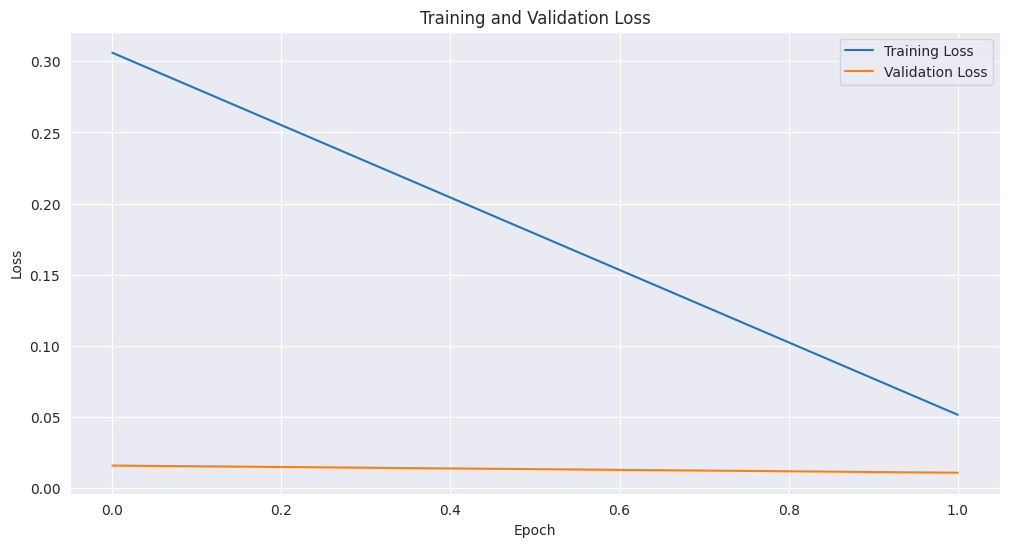

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Plot akurasi

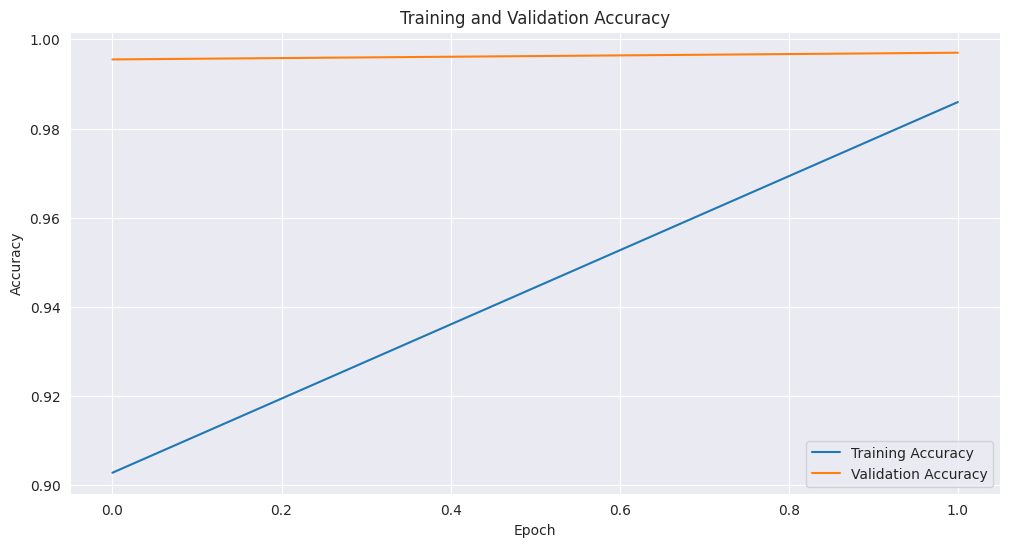

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Simpan model untuk digunakan nanti

In [18]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Karenan nanti saya ingin mencoba mendeploy model ke web saya coba convert model.h5 ke TFJS

In [25]:
input_model_path = 'model.h5'
output_dir = 'tfjs_model'

command = f"tensorflowjs_converter --input_format=keras {input_model_path} {output_dir}"

Terakhir Kompres model nya agar mudah didownload

In [26]:
zip_filename = 'tfjs_model.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('tfjs_model'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), 'tfjs_model'))